In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# --- 1. SETUP PATHS (KAGGLE VERSION) ---
# Kaggle mounts datasets at /kaggle/input
base_dir = r'/kaggle/input/chest-xray-pneumonia/chest_xray'

# Kaggle datasets sometimes have a nested folder structure
# If this fails, we will try the alternative path
if not os.path.exists(base_dir):
    base_dir = r'/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = os.path.join(base_dir, 'val')

print(f"Checking path: {train_dir}")
if os.path.exists(train_dir):
    print("SUCCESS: Dataset found!")
else:
    print("ERROR: Path not found. Check the 'Input' section on the right sidebar.")

# --- 2. IMAGE CONFIGURATION ---
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# --- 3. DATA GENERATORS ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# --- 4. LOAD DATA ---
print("\n--- LOADING DATA ---")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# --- 5. CALCULATE CLASS WEIGHTS ---
print("\n--- COMPUTING CLASS WEIGHTS ---")
train_labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights_dict = dict(enumerate(class_weights))
print(f"Class Weights: {class_weights_dict}")

2025-11-29 12:59:46.643316: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764421187.038734      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764421187.158974      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Checking path: /kaggle/input/chest-xray-pneumonia/chest_xray/train
SUCCESS: Dataset found!

--- LOADING DATA ---
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.

--- COMPUTING CLASS WEIGHTS ---
Class Weights: {0: 1.9448173005219984, 1: 0.6730322580645162}


In [3]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# --- 1. LOAD THE PRE-TRAINED BASE ---
# include_top=False removes the final classification layer (which was for 1000 things)
# We only want the feature extractor part.
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# --- 2. FREEZE THE BASE ---
# We don't want to retrain these layers yet.
base_model.trainable = False

# --- 3. BUILD THE CUSTOM MODEL ---
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),      # Condense the data
    layers.Dense(128, activation='relu'), # Learn patterns
    layers.Dropout(0.3),                  # Drop 30% of neurons randomly (prevents overfitting)
    layers.Dense(1, activation='sigmoid') # Output: 0 (Normal) to 1 (Pneumonia)
])

# --- 4. COMPILE (SETTINGS) ---
# We use a low learning rate (0.0001) to be gentle with the weights
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

print(model.summary())

# --- 5. DEFINE CALLBACKS (SAFETY NETS) ---
# Save the model only when it improves
checkpoint = ModelCheckpoint(
    "best_xray_model.keras", 
    monitor='val_loss', 
    save_best_only=True, 
    mode='min', 
    verbose=1
)

# Stop training if it stops improving for 5 epochs (saves time)
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True,
    verbose=1
)

# --- 6. START TRAINING ---
print("\n--- STARTING TRAINING ---")
history = model.fit(
    train_generator,
    epochs=20,                    # Maximum laps
    validation_data=val_generator,# Check performance here
    class_weight=class_weights_dict, # Use the weights we calculated earlier
    callbacks=[checkpoint, early_stopping]
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None

--- STARTING TRAINING ---
Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.5136 - loss: 0.6923 - precision: 0.7905 - recall: 0.4615
Epoch 1: val_loss improved from inf to 0.59300, saving model to best_xray_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 113s 676ms/step - accuracy: 0.5141 - loss: 0.6921 - precision: 0.7908 - recall: 0.4622 - val_accuracy: 0.8125 - val_loss: 0.5930 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.7711 - loss: 0.5632 - precision: 0.9125 - recall: 0.7638
Epoch 2: val_loss improved from 0.59300 to 0.52657, saving model to best_xray_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 571ms/step - accuracy: 0.7712 - loss: 0.5631 - precision: 0.9126 - recall: 0.7639 - val_accuracy: 0.8125 - val_loss: 0.5266 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.8308 - loss: 0.4805 - precision: 0.9507 - recall: 0.8081
Epoch 3: val

In [4]:
# --- 1. UNFREEZE THE TOP LAYERS ---
# We unfreeze the last block of VGG16 (Block 5)
base_model.trainable = True

set_trainable = False
for layer in base_model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# --- 2. RE-COMPILE WITH TINY LEARNING RATE ---
# Critical: Use a learning rate 10x smaller (1e-5) to gently nudge weights
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Recall(name='recall')]
)

# --- 3. CONTINUE TRAINING ---
print("\n--- STARTING FINE-TUNING ---")
history_fine = model.fit(
    train_generator,
    epochs=10,  # Train for a few more rounds
    validation_data=val_generator,
    class_weight=class_weights_dict
)


--- STARTING FINE-TUNING ---
Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 568ms/step - accuracy: 0.9144 - loss: 0.2141 - recall: 0.9079 - val_accuracy: 0.7500 - val_loss: 0.5489 - val_recall: 1.0000
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 92s 566ms/step - accuracy: 0.9432 - loss: 0.1415 - recall: 0.9397 - val_accuracy: 0.9375 - val_loss: 0.2216 - val_recall: 0.8750
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 567ms/step - accuracy: 0.9508 - loss: 0.1151 - recall: 0.9443 - val_accuracy: 0.9375 - val_loss: 0.1707 - val_recall: 0.8750
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 570ms/step - accuracy: 0.9554 - loss: 0.1087 - recall: 0.9512 - val_accuracy: 0.9375 - val_loss: 0.2090 - val_recall: 0.8750
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 572ms/step - accuracy: 0.9624 - loss: 0.0959 - recall: 0.9576 - val_accuracy: 0.9375 - val_loss: 0.1530 - val_recall: 0.8750
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 98s 602ms/step - accuracy: 0.9680 - loss: 0.0834 - recall: 0.9625 - val_accuracy: 0.9

Evaluating on Test Set...
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 261ms/step - accuracy: 0.8931 - loss: 0.2907 - recall: 0.6169

Test Accuracy: 90.87%
Test Recall:    93.33%
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 267ms/step


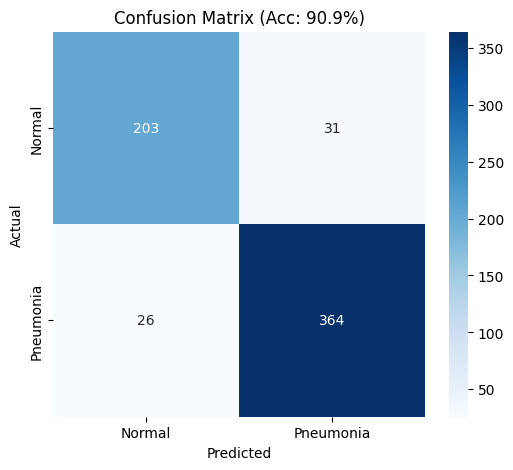

              precision    recall  f1-score   support

      Normal       0.89      0.87      0.88       234
   Pneumonia       0.92      0.93      0.93       390

    accuracy                           0.91       624
   macro avg       0.90      0.90      0.90       624
weighted avg       0.91      0.91      0.91       624



In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. RUN EVALUATION ---
print("Evaluating on Test Set...")
results = model.evaluate(test_generator)

# FIXED INDICES HERE:
print(f"\nTest Accuracy: {results[1]*100:.2f}%")
print(f"Test Recall:    {results[2]*100:.2f}%") # Changed from [3] to [2]

# --- 2. GET PREDICTIONS ---
predictions = model.predict(test_generator)
y_pred = (predictions > 0.5).astype(int).flatten()
y_true = test_generator.classes

# --- 3. CONFUSION MATRIX ---
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Acc: {results[1]*100:.1f}%)')
plt.show()

# --- 4. DETAILED REPORT ---
print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))

Analyzing Image #0 in batch 0...
Model Confidence: 99.99% Pneumonia


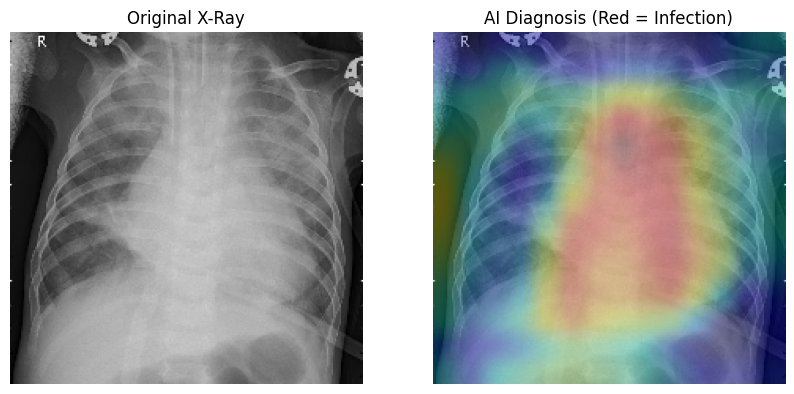

In [12]:
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib

# --- 1. THE FIXED GRAD-CAM ALGORITHM ---
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # ACCESS THE INTERNAL VGG16 MODEL
    # Your model is a wrapper. Layer 0 is VGG16.
    base_model = model.layers[0] 

    # PART A: Create a model that outputs the Conv Layer AND VGG's final output
    base_grad_model = tf.keras.models.Model(
        inputs=[base_model.input], 
        outputs=[base_model.get_layer(last_conv_layer_name).output, base_model.output]
    )

    # PART B: Record the flow of data
    with tf.GradientTape() as tape:
        # 1. Pass the image through VGG16 first
        conv_outputs, base_outputs = base_grad_model(img_array)
        
        # 2. Pass that output through your CUSTOM layers (Dense, Dropout, etc.)
        # We manually loop through layers 1, 2, 3... of your main model
        preds = base_outputs
        for layer in model.layers[1:]:
            preds = layer(preds)

        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # PART C: Calculate Gradients
    # Gradient of the "Pneumonia" class with regard to the Conv Layer
    grads = tape.gradient(class_channel, conv_outputs)
    
    # Average the gradients (Global Average Pooling)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # PART D: Generate Heatmap
    conv_outputs = conv_outputs[0]
    
    # Weight the channels by their importance
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize between 0 and 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# --- 2. PICK A 'PNEUMONIA' IMAGE TO TEST ---
found_image = False
# We iterate through the test generator to find a strong positive case
for i in range(len(test_generator)):
    batch_imgs, batch_labels = next(test_generator)
    preds = model.predict(batch_imgs, verbose=0)
    
    for j in range(len(batch_labels)):
        # We look for a True Positive (Label=1) with High Confidence (>0.9)
        if batch_labels[j] == 1 and preds[j] > 0.9:
            img_tensor = np.expand_dims(batch_imgs[j], axis=0)
            original_img = batch_imgs[j]
            print(f"Analyzing Image #{j} in batch {i}...")
            print(f"Model Confidence: {preds[j][0]*100:.2f}% Pneumonia")
            found_image = True
            break
    if found_image: break

# --- 3. GENERATE HEATMAP ---
# We pass the VGG16 layer name 'block5_conv3'
# If this fails, try 'block5_conv3' or check model.layers[0].summary()
heatmap = make_gradcam_heatmap(img_tensor, model, 'block5_conv3')

# --- 4. OVERLAY HEATMAP ON IMAGE ---
def display_gradcam(img, heatmap, alpha=0.4):
    # Rescale heatmap to 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap
    jet = matplotlib.colormaps.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose
    superimposed_img = jet_heatmap * alpha + img * 255
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original X-Ray")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title("AI Diagnosis (Red = Infection)")
    plt.axis('off')
    plt.show()

display_gradcam(original_img, heatmap)

In [13]:
model.save('pneumonia_detection_model_vgg16.keras')
print("Model saved successfully!")

Model saved successfully!
